# Final notebook

This notebook brings essentially the final polished up
result of what I have done so far. That is, it will bring
the functions which will make the plots which will be using
for the webapp.

In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import time

## First part

### Number of burning events for an specific year

> The function below receives the year and returns
the figure containing two plots: the burning events
distribution and the brazilian biome distribution.

In [2]:
def burning_given_year(year, ax1, ax2, fig):
    
    filename = 'cleaned-datasets/entire_country{}.csv'.format(str(year))
    df = pd.read_csv(filename,
                     parse_dates = [0])
    
    ## Rounding the numbers for better visualization
    df = df.round(0)

    ## CREATING A NEW SIMPLE DF WITH THE PERTINENT INFORMATION
    df_loc_gb = df.groupby(['latitude', 'longitude'])

    number_events = []
    lat = []
    long = []

    for info, dataframe in df_loc_gb:
        lat.append(info[0])
        long.append(info[1])
        number_events.append(len(dataframe))
    
    ##THE DATAFRAME ITSELF
    blaze_df = pd.DataFrame()

    blaze_df['latitude']= lat
    blaze_df['longitude'] = long
    blaze_df['number_events'] = number_events

    plot = ax1.scatter(x = long, y = lat, c = blaze_df.number_events/1000, cmap = 'cividis_r')
    ax1.set_title('Burning events in {} \nin Thousands'.format(year), fontsize = 16)
    ax1.set_xlabel('Latitude', fontsize = 14)
    ax1.set_ylabel('Longitude', fontsize = 14)

    ## EDITTING THE COLOR BAR POSITION

    position = fig.add_axes([0.46, 0.125, 0.015, 0.755])

    plt.colorbar(plot, cax=position)

    plt.subplots_adjust(wspace = 0.35)
    
    
    ## Brazil map per biome

    ax2.set_xlabel('Latitude', fontsize = 14)
    ax2.set_ylabel('Longitude', fontsize = 14)
    
    mpl.rcParams['agg.path.chunksize'] = 10000
    
    df = pd.read_csv('cleaned-datasets/data-map.csv')
    
    biomes = ['Amazonia', 'Mata Atlantica', 'Cerrado', 'Pampa', 'Caatinga', 'Pantanal']
    colors = ['indianred', 'yellowgreen', 'cadetblue', 'mediumpurple', 'lightsteelblue', 'bisque']
    
    color_dict = dict(zip(biomes, colors))
    
    biome_gb = df.groupby('bioma')

    for biome_name, df in biome_gb:
        ax2.plot(df.longitude, df.latitude, marker = 'o',
                 label = biome_name, linestyle='', c = color_dict[biome_name])

    ax2.set_title('Brazilian biomes', fontsize = 14)
    ax2.legend(loc = 'lower left')
    
    return ax1, ax2

Running time: 3.0392069816589355


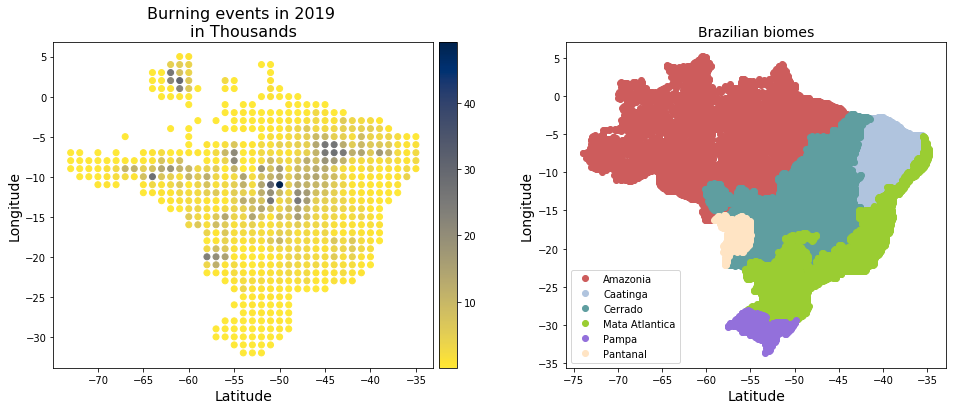

In [6]:
start_time = time.time()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,6))

burning_given_year(2019, ax1, ax2, fig)

print("Running time: {}".format((time.time() - start_time)))

plt.show()

## Second part

### Number of burning events in the map of Brazil for a given biome

The function below will be responsible for taking the the year
and biome information and it will give back to the user the 
plots concerning the forementioned information.

In [32]:
def burning_map_brazil(ax, year, biome, cbar_location = [0.92, 0.1, 0.015, 0.78]):
        
    df_map = pd.read_csv('cleaned-datasets/data-map.csv')
    
    filename = 'cleaned-datasets/timeseries{}{}.csv'.format(str(year), biome)
    
    df = pd.read_csv(filename, parse_dates = [0], usecols = ['bioma', 'latitude', 'longitude'])
    
    gb_biome = df_map.groupby('bioma')

    ## CREATING THE INFORMATION RELATED TO DESIRED BIOME
    
    df['latitude'] = df['latitude'].round(1) 
    df['longitude'] = df['longitude'].round(1) 

    gb_loc = df.groupby(['latitude', 'longitude'])

    latitude = []
    longitude = []
    number_events = []

    for info, df in gb_loc:
        latitude.append(info[0])
        longitude.append(info[1])
        number_events.append(len(df))
    
    ## EDITING THE AXIS
    
    ax.set_xlabel('Latitude', fontsize = 14)
    ax.set_ylabel('Longitude', fontsize = 14)

    mpl.rcParams['agg.path.chunksize'] = 10000

    plot = ax.scatter(x = longitude, y = latitude, c = number_events, cmap = 'magma_r')
    
    biomes = ['Amazonia', 'Mata Atlantica', 'Cerrado', 'Pampa', 'Caatinga', 'Pantanal']
    colors = ['indianred', 'yellowgreen', 'cadetblue', 'mediumpurple', 'lightsteelblue', 'bisque']
    
    color_dict = dict(zip(biomes, colors))

    for biome_name, df in gb_biome:
        if biome_name != biome:
            ax.plot(df.longitude, df.latitude, marker = 'o', label = biome_name,
                    linestyle='', alpha = 0.4, c = color_dict[biome_name])

    ax.set_title('Brazilian biomes distribution and \nburning events at the {} in {}'.format(biome, str(year)) ,fontsize = 16)
    ax.legend(loc = 'lower left')

    ## EDITTING THE COLOR BAR POSITION

    position=fig.add_axes(cbar_location)

    fig.colorbar(plot, cax=position)

    plt.subplots_adjust(wspace = 0.35)

    return ax

Running time: 3.395202398300171


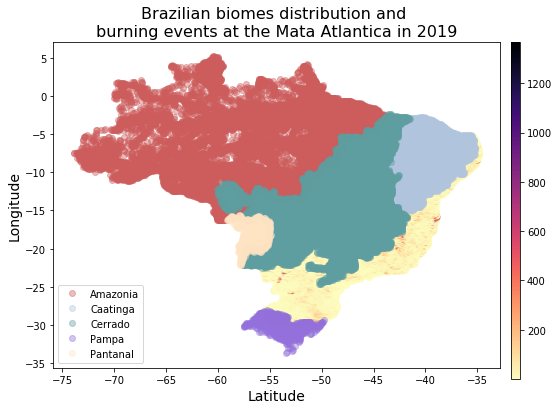

In [33]:
fig, ax = plt.subplots(figsize = (8,6))

start_time = time.time()

burning_map_brazil(ax, 2019, 'Mata Atlantica')

print("Running time: {}".format((time.time() - start_time)))

plt.show()

In [36]:
def biome_plot(ax, year, biome, rolling_mean = 3,
               day1 = 31, day2 = 20, month1 = 7, month2 = 11, inset_location = [0.2, 0.6, .2, .2]):
    
    ## BURNED DATAFRAME FOR AN SPECIFIC BIOME
    filename = 'cleaned-datasets/timeseries{}{}.csv'.format(str(year), biome)
    df = pd.read_csv(filename, parse_dates = [0], usecols = ['data', 'precipitacao', 'riscofogo'])
    
    df_burned_biome = df[df.riscofogo == 1].copy()
    
    gb_date = df_burned_biome.groupby('data')
    
    date = []
    occurrence = []
    for date1, dataframe in gb_date:
        date.append(date1)
        occurrence.append(len(dataframe))
        
    date = pd.Series(date)
    occurrence = pd.Series(occurrence)
    
    ## COUNTING THE AVERAGE OF PRECIPITATION PER BIOME PER DAY
    
    precipitation = []
    date_prec = []
    gb_date_all = df.groupby('data')

    for date1, dataframe in gb_date_all:
        mean_prec = dataframe['precipitacao'].mean()
        date_prec.append(date1)
        precipitation.append('%.2f'%mean_prec)
        
    precipitation = pd.Series(precipitation)
    date_prec = pd.Series(date_prec)    
    
    ## PLOTTING SECTION ##
    
    ax.set_xlabel('Date', fontsize = 16)
    ax.set_ylabel('Number of events', fontsize = 16)
    ax.set_title('Number of burning incidents in Brazil\n at the {} in {}'.format(biome, year),
                 fontsize = 16)

    #plt.xticks(rotation = 45)
    ax.set_xlim(datetime.date(year, 1, 1), datetime.date(year, 12, 31) )
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
    plt.xticks(rotation = 45)

    x1 = datetime.date(year, month1, day1)
    x2 = datetime.date(year, month2, day2)
    
    
    ax.axvspan(x1, x2, color='gray', alpha=0.2, lw=0)

    ax.plot(date, occurrence.rolling(window = rolling_mean).mean(),
    c = 'salmon')
    
    ax_inset = plt.axes(inset_location)
    ax_inset.set_xlim(datetime.datetime(year,1,1), datetime.datetime(year, 12, 31))
    ax_inset.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax_inset.plot(date_prec, precipitation.rolling(window = 4).mean())
    
    
    
    ax_inset.axvspan(x1, x2, color='gray', alpha=0.3, lw=0)
        
    plt.xticks(rotation = 45)
    plt.title('Precipitation')

    return ax

Running time: 2.0222578048706055


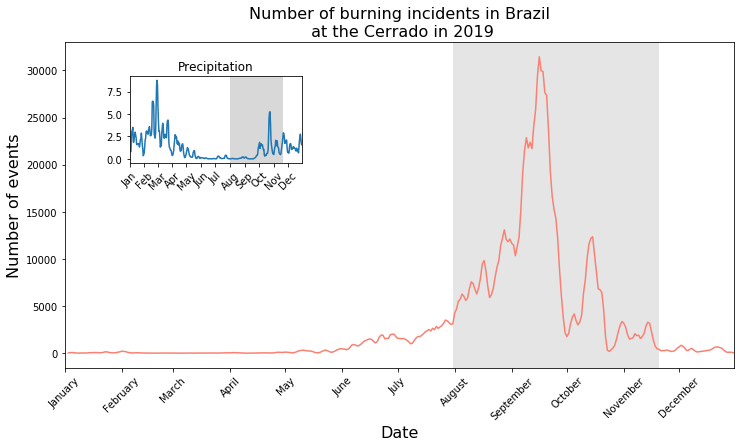

In [41]:
fig, ax = plt.subplots(figsize = (12, 6))

start_time = time.time()

biome_plot(ax, 2019, 'Cerrado')

print("Running time: {}".format((time.time() - start_time)))

plt.show()

### Pie chart creation

This aims for creating the pertinent pie chart of the desired year

In [43]:
def pie_chart_year(ax, year, biome):
    
    biomes = ['Amazonia', 'Mata Atlantica', 'Cerrado', 'Pampa', 'Caatinga', 'Pantanal']
    burn_ev = []
    
    ## COUNTING THE NUMBER OF BURNING EVENTS PER BIOME FOR AN SPECIFIC YEAR    
    for biome_for_loop in biomes:
        filename = 'cleaned-datasets/peryear{}{}.csv'.format(str(year), biome_for_loop)
        df = pd.read_csv(filename, usecols = ['riscofogo'])
        burn_ev.append(len(df.index))    
    
    ## EXPLODING THE DESIRED BIOME
    
    index = biomes.index(biome)
    explode = [0, 0, 0, 0.1, 0, 0]
    explode[index] = 0.1
    
    ## PLOTTING
    colors = ['indianred', 'yellowgreen', 'cadetblue', 'black', 'lightsteelblue', 'bisque']
    
    ax.pie(burn_ev, labels = biomes, autopct='%1.1f%%',
           explode = explode, startangle=-90, colors = colors)
    ax.axis('equal')
    ax.set_title('Number of burning events \nper biome in {}'.format(year),
                 fontsize = 16)
    
    #ADDING A WHITE CIRCLE AT THE CENTER (DONUT CHART)
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    ax.add_patch(centre_circle)
    
    return ax

Running time: 0.8409581184387207


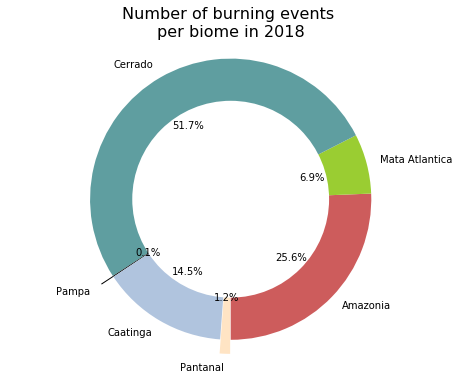

In [45]:
fig, ax = plt.subplots(figsize = (8,6))

start_time = time.time()

pie_chart_year(ax, 2018, 'Pantanal')

print("Running time: {}".format((time.time() - start_time)))

plt.show()

## CREATING THE COMPOSED FUNCTION OF ALL THREE ABOVE FOR A SINGLE PLOT 

Running time: 2.3253965377807617


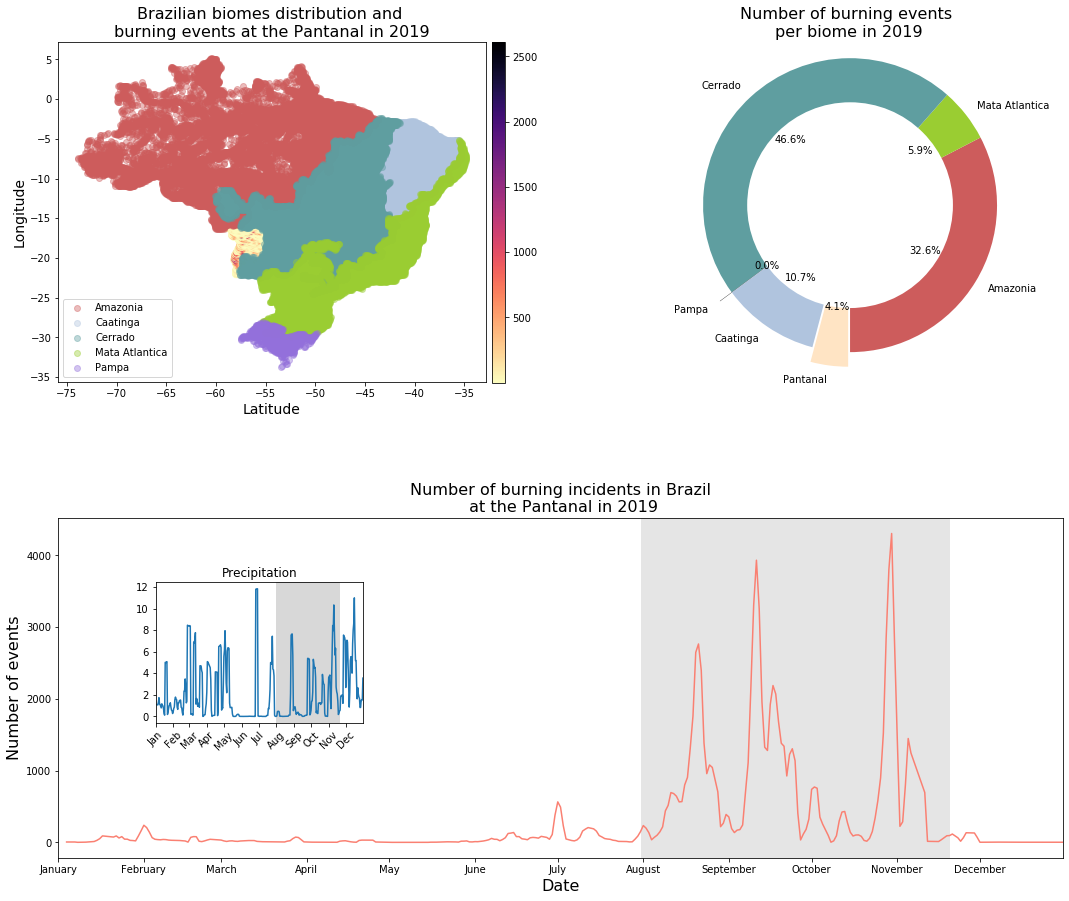

In [49]:
fig = plt.figure(figsize = (18,15))

gs = fig.add_gridspec(2, 2, hspace = 0.4)

ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[0,-1])
ax3 = fig.add_subplot(gs[1, :])



start_time = time.time()

burning_map_brazil(ax1, 2019, 'Pantanal', cbar_location = [0.46, 0.565, 0.01, 0.315])
pie_chart_year(ax2, 2019, 'Pantanal')
biome_plot(ax3, 2019, 'Pantanal', inset_location = [0.2, 0.25, .16, .13])

print("Running time: {}".format((time.time() - start_time)))

plt.show()

Running time: 9.98259687423706


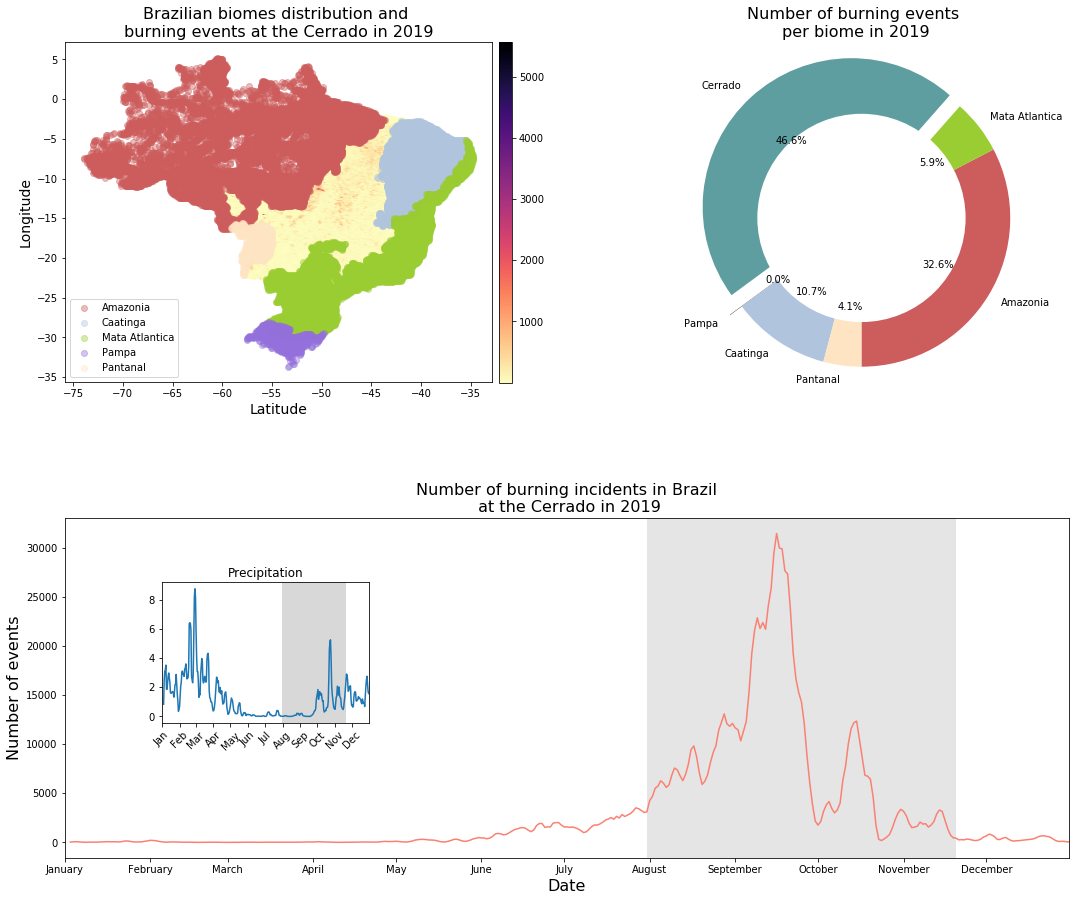

In [51]:
fig = plt.figure(figsize = (18,15))

gs = fig.add_gridspec(2, 2, hspace = 0.4)

ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[0,-1])
ax3 = fig.add_subplot(gs[1, :])

start_time = time.time()

burning_map_brazil(ax1, 2019, 'Cerrado',  cbar_location = [0.46, 0.565, 0.01, 0.315])
pie_chart_year(ax2, 2019, 'Cerrado')
biome_plot(ax3, 2019, 'Cerrado', inset_location = [0.2, 0.25, .16, .13])

print("Running time: {}".format((time.time() - start_time)))

plt.show()

Running time: 5.107845783233643


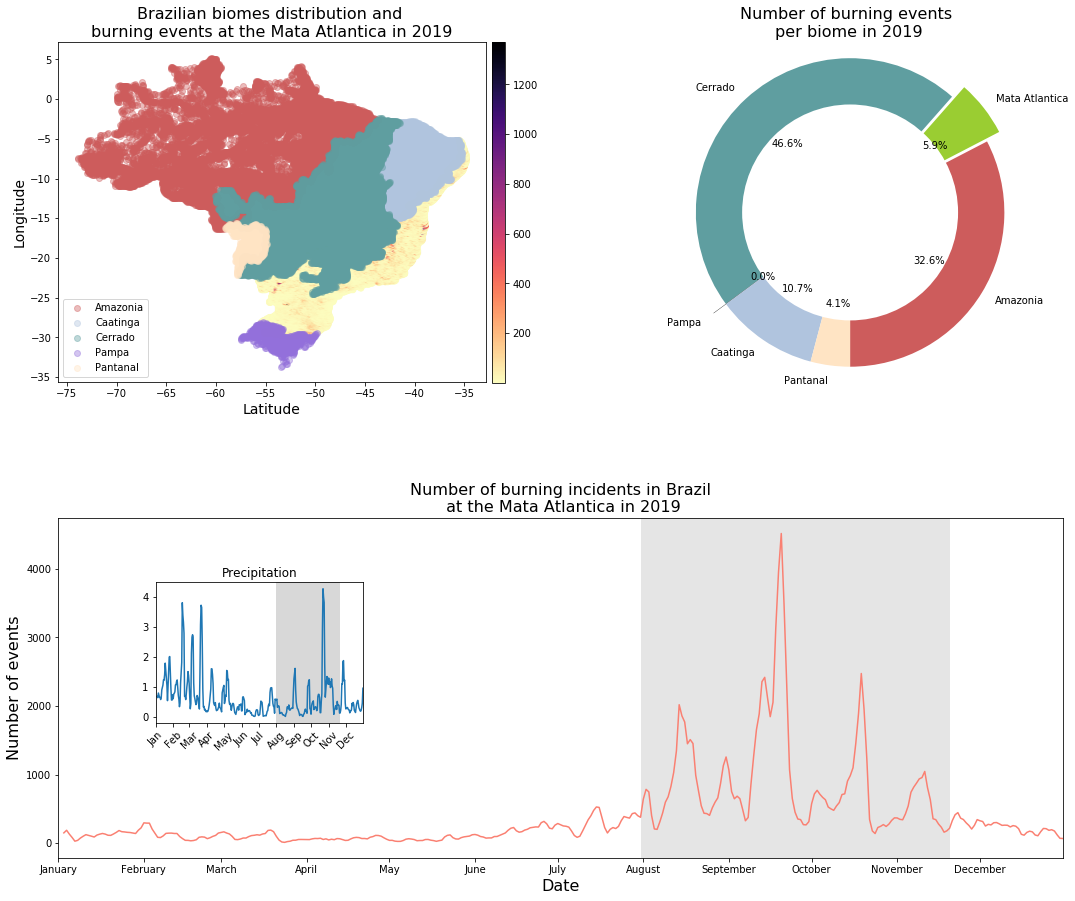

In [53]:
fig = plt.figure(figsize = (18,15))

gs = fig.add_gridspec(2, 2, hspace = 0.4)

ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[0,-1])
ax3 = fig.add_subplot(gs[1, :])

start_time = time.time()

burning_map_brazil(ax1, 2019, 'Mata Atlantica',  cbar_location = [0.46, 0.565, 0.01, 0.315])
pie_chart_year(ax2, 2019, 'Mata Atlantica')
biome_plot(ax3, 2019, 'Mata Atlantica', inset_location = [0.2, 0.25, .16, .13])

print("Running time: {}".format((time.time() - start_time)))

plt.show()